In [3]:
# preparing data
from sklearn.decomposition import PCA

from models import *
from methods import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "DSVDD"
DATASET = 'full_data'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = [True]
TRIM_DATA = [True]
FILTER_CORRCOEF = [True]
REMOVE_NOISE = [True]
NOISE_THRESHOLD = [10]
DENOISE = [False]
NOISE_FACTOR = [0.05]
NOISE_FRACTION = [0.8]
NORMALIZE_DATA = [False]
NORMALIZATION_SCHEME = ['standard_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']
# model parameters
HIDDEN_DIM = [16,64]
ACTIVATION = 'leaky_relu'
INITIALIZATION = 'xavier_normal'
OUTPUT_FEATURE = [4, 16, 256]
# training parameters
WEIGHT_DECAY = [1e-6, 1e0]
LEARNING_RATE = [1e-4]
EPOCHS = [4000]
BATCH_SIZE = [1024]
ALGO = 'SGD'
V = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
GAMMA = [1e-0, 1e-2]
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)

In [4]:
import itertools
for trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # process data
        train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=trim_data, trim_threshold=0.98, normalize=normalize_data,
            filterLinearDependencies=True, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
        train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
        num_feature = len(train_data[0])
        print(train_data.shape)
        print(torch.max(anomalous_data))

        criterion = lambda *args: 0
        R = torch.tensor(1, dtype=float, requires_grad=True)
        for output_feature, v, gamma, hidden_dim, activation, initialization in itertools.product(OUTPUT_FEATURE, V, GAMMA, HIDDEN_DIM, ACTIVATION, INITIALIZATION):
                for algo, epochs, batch_size, learning_rate, weight_decay in itertools.product(ALGO, EPOCHS, BATCH_SIZE, LEARNING_RATE, WEIGHT_DECAY):
                        # initialize model
                        model = DSVDD(num_feature, output_feature=output_feature, center=torch.tensor([[0]]), v=v, R=R, gamma=gamma, hidden_dim=hidden_dim, activation=activation, initialization=initialization,)
                        # train     
                        if normalize_data:
                                loss_array = train(model, algo, epochs, train_data, train_data, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                                        ,grad_limit=1e2,)
                        else:
                                loss_array = train(model, algo, epochs, train_data, train_data, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                                ,grad_limit=1e3,)
                        torch.save(model.state_dict(), '../model/param_DSVDD')

                        # evaluation
                        model.eval()

                        train_code = model(train_data)
                        train_code_square = torch.sum((train_code - model.center) ** 2, dim=1, keepdim=True)
                        print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
                        print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
                        print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))
                        test_code_sqaure, anomalous_code_square = torch.sum((model(test_data) - model.center)** 2, dim=1, keepdim=True), torch.sum((model(anomalous_data) - model.center)** 2, dim=1, keepdim=True)
                        test_specificity, test_sensitivity = 1 - torch.sum(test_code_sqaure > model.R**2)/ test_data.shape[0], torch.sum(anomalous_code_square > model.R**2)/ anomalous_data.shape[0]
                        print(f"\nTrain code outside hypersphere percentage: {(torch.sum(train_code_square > model.R.item() ** 2)/ train_data.shape[0]).item()}")
                        print(f"Test code outside hypersphere percentage: {1-test_specificity}")
                        print(f"Anomalous code outside hypersphere percentage: {test_sensitivity}\n")
                        d = {"Train specificity":(torch.sum(train_code_square <= model.R.item() ** 2)/ train_data.shape[0]).item(), 
                        "Test specificity":test_specificity, 
                        "Test sensitivity(recall)":test_sensitivity}
                        parameters = {"trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
                                "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                                "output feature":output_feature,"R":model.R,"v":v,"gamma":gamma,"hidden_dim": hidden_dim,
                                "activation": activation, "initialization": initialization, "weight_decay": weight_decay, "learning_rate": learning_rate, "batch_size": batch_size, "epochs": epochs,
                                "Train specificity":(torch.sum(train_code_square <= model.R.item() ** 2)/ train_data.shape[0]).item(), 
                                "Test specificity":(torch.sum(torch.sum((model(test_data)-model.center) ** 2, dim=1, keepdim=True) <= model.R.item() ** 2)/ test_data.shape[0]).item(), 
                                "Test sensitivity(recall)":(torch.sum(torch.sum((model(anomalous_data)-model.center) ** 2, dim=1, keepdim=True) > model.R.item() ** 2)/ anomalous_data.shape[0]).item()
                                }
                        plot_bar(d, model_name, True, save_path='../graphs/DSVDD/sensitivity_specificity', **parameters)
                        plt.close('all')

Train data shape after trim:  (8005, 16)
Train data shape after filter corrcoef:  (8005, 12)
removeNoise = True ---- remaining Data Shape =  (7988, 12)
Train data shape after normalize:  (7988, 12)
torch.Size([7988, 12])
tensor(311623.)
epoch : 1/4000, loss = 873840.014065
epoch : 2/4000, loss = 46911.915512
epoch : 3/4000, loss = 3869.116349
epoch : 4/4000, loss = 4689.784796
epoch : 5/4000, loss = 367.246793
epoch : 6/4000, loss = 187.738627
epoch : 7/4000, loss = 0.001900
epoch : 8/4000, loss = 0.001899
epoch : 9/4000, loss = 0.001899
epoch : 10/4000, loss = 0.001899
epoch : 11/4000, loss = 0.001899
epoch : 12/4000, loss = 0.001899
epoch : 13/4000, loss = 0.001899
epoch : 14/4000, loss = 0.001898
epoch : 15/4000, loss = 0.001898
epoch : 16/4000, loss = 0.001898
epoch : 17/4000, loss = 0.001898
epoch : 18/4000, loss = 0.001898
epoch : 19/4000, loss = 0.001898
epoch : 20/4000, loss = 0.001898
epoch : 21/4000, loss = 0.001897
epoch : 22/4000, loss = 0.001897
epoch : 23/4000, loss = 0.0

KeyboardInterrupt: 

torch.Size([2046, 4])
Train average loss:0.0
Train code square: tensor([[0.0642],
        [0.0366],
        [0.0627],
        ...,
        [0.0260],
        [0.0537],
        [0.0359]], grad_fn=<SumBackward1>)
Train error: 0.1369172606871886, Train R square: 0.11379067874085423
Validation average loss:0.0
Test average loss:  0.0
Anomalous average loss:  0.0

Train code outside hypersphere percentage: 0.0
Test code outside hypersphere percentage: 0.0018733739852905273
Anomalous code outside hypersphere percentage: 0.027370478957891464



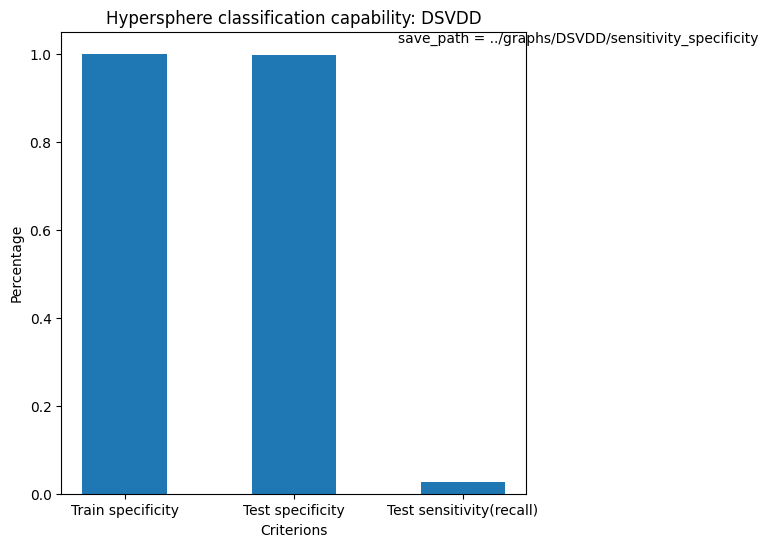

In [ ]:
# evaluation
print(anomalous_data.shape)
model.eval()

train_code = model(train_data)
train_code_square = torch.sum((train_code - model.center) ** 2, dim=1, keepdim=True)
print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")
print(f"Train code square: {train_code_square}")
print(f"Train error: {model.error}, Train R square: {model.R.item() ** 2}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))
test_code_sqaure, anomalous_code_square = torch.sum((model(test_data) - model.center)** 2, dim=1, keepdim=True), torch.sum((model(anomalous_data) - model.center)** 2, dim=1, keepdim=True)
test_specificity, test_sensitivity = 1 - torch.sum(test_code_sqaure > model.R**2)/ test_data.shape[0], torch.sum(anomalous_code_square > model.R**2)/ anomalous_data.shape[0]
print(f"\nTrain code outside hypersphere percentage: {(torch.sum(train_code_square > model.R.item() ** 2)/ train_data.shape[0]).item()}")
print(f"Test code outside hypersphere percentage: {1-test_specificity}")
print(f"Anomalous code outside hypersphere percentage: {test_sensitivity}\n")
d = {"Train specificity":(torch.sum(train_code_square <= model.R.item() ** 2)/ train_data.shape[0]).item(), 
    "Test specificity":test_specificity, 
    "Test sensitivity(recall)":test_sensitivity}
plot_bar(d, model_name, False, save_path='../graphs/DSVDD/sensitivity_specificity')

In [ ]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if False:
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

AttributeError: 'DSVDD' object has no attribute 'encode'

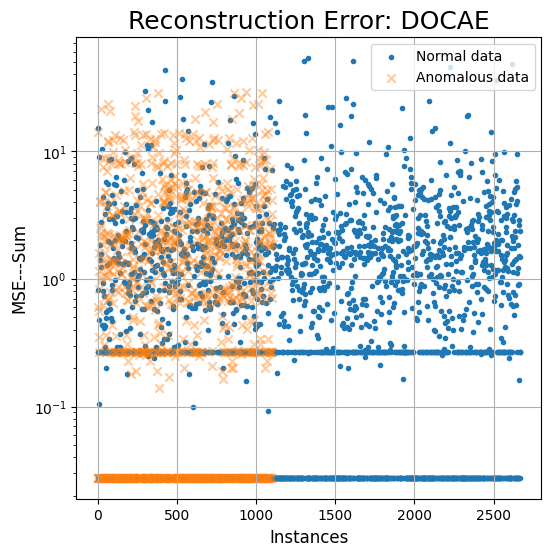

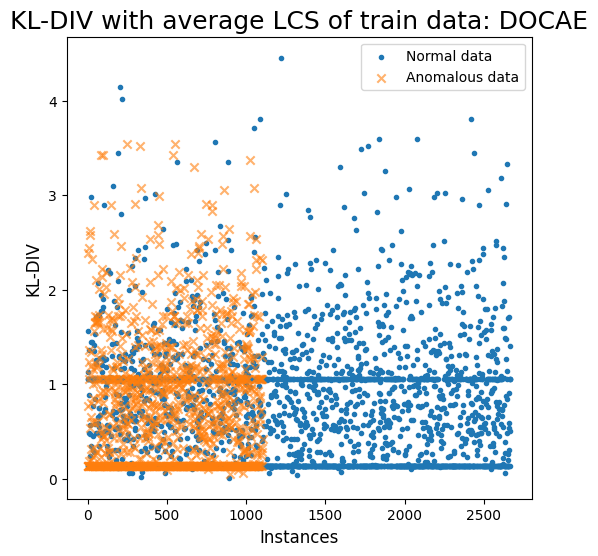

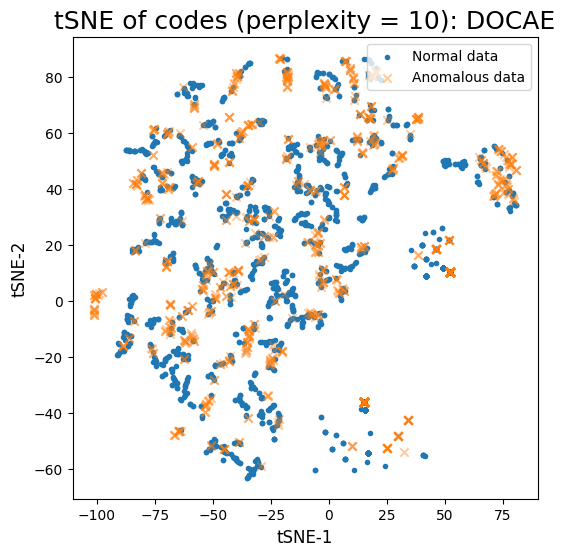

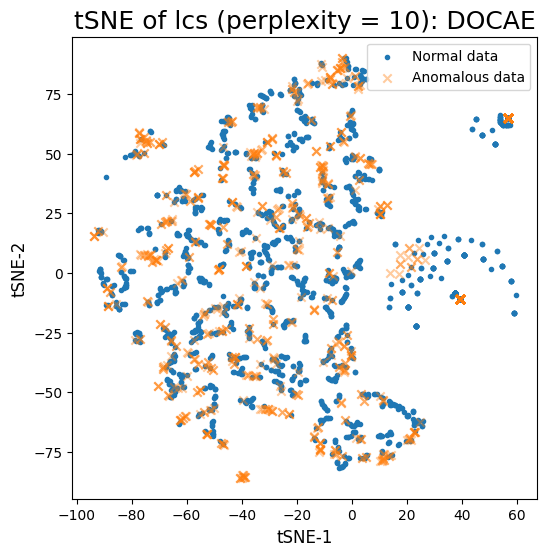

In [ ]:
import matplotlib.pyplot as plt
plot1_upper_lim = 1e12
plot1_lower_lim = 0e-1
if True:
    fig = plt.figure(figsize = (6,6))

    ax = fig.add_subplot(1,1,1)

    ax.set_xlabel('Instances', fontsize = 12)
    ax.set_ylabel('MSE---Sum', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error: ' + model_name, fontsize = 18)
    ax.grid()
    ax.scatter(np.arange(len(loss_test)), loss_test, marker=".").set_label('Normal data')
    ax.scatter(np.arange(len(loss_attack)), loss_attack, marker="x", alpha=0.4).set_label('Anomalous data')
    #ax.set_ylim(plot1_lower_lim, plot1_upper_lim)
    ax.legend()

    fig2 = plt.figure(figsize = (6,6))
    
    ax2 = fig2.add_subplot(1,1,1)
    ax2.scatter(np.arange(len(kl_div_test)), kl_div_test, marker=".").set_label('Normal data')
    ax2.scatter(np.arange(len(kl_div_attack)), kl_div_attack, marker="x", alpha=0.6).set_label('Anomalous data')
    ax2.set_title('KL-DIV with average LCS of train data: ' + model_name, fontsize = 18)
    ax2.set_xlabel('Instances', fontsize = 12)
    ax2.set_ylabel('KL-DIV', fontsize = 12)
    #ax2.set_ylim(0, 2e-1)
    ax2.legend()

    # Plot the result of our TSNE with the label color coded
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

    # Plot the result of TSNE
    fig4 = plt.figure(figsize = (6,6))
    ax4 = fig4.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax4.scatter(tsne_lcs[:l1,0], tsne_lcs[:l1,1], 
    #np.arange(l1), 
    marker=".").set_label('Normal data')
    ax4.scatter(tsne_lcs[l1:,0], tsne_lcs[l1:,1], 
    #np.arange(l2), 
    marker="x", alpha=0.4).set_label('Anomalous data')
    ax4.set_title(('tSNE of lcs (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax4.set_xlabel('tSNE-1', fontsize = 12)
    ax4.set_ylabel('tSNE-2', fontsize = 12)
    ax4.legend()

<Figure size 500x500 with 0 Axes>

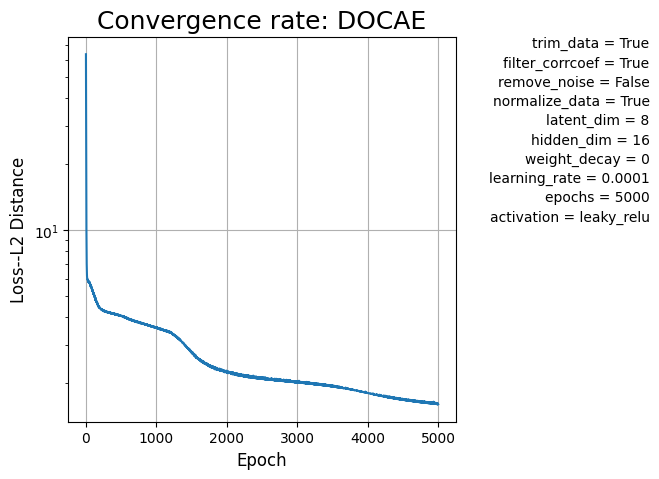

In [ ]:
# convergence
def visualize_convergence(loss_array,  model_name:str, save:bool=False, **kwargs):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    ax.set_title('Convergence rate: ' + model_name, fontsize = 18)
    ax.grid()
    ax.plot(loss_array)
    # annotate graph
    x, y, i = 1.5, 1, 1
    for key, value in kwargs.items():
        ax.text(x, y, str(key) + " = " + str(value), ha='right', va='top', transform = ax.transAxes)
        y -= 0.05
    # save graph
    if save:
        path = "../graphs/Convergence"
        filename = model_name
        pathfile = os.path.normpath(os.path.join(path, filename))
        if not os.path.exists(path):
            os.makedirs(path)
        while os.path.isfile(pathfile + '.png'):
            pathfile = os.path.normpath(os.path.join(path, filename + str(i)))
            i += 1
        fig.savefig(pathfile)
    return ax

fig = plt.figure(figsize = (5, 5))
parameters = {"trim_data": TRIM_DATA, "filter_corrcoef": FILTER_CORRCOEF, "remove_noise": REMOVE_NOISE,
"normalize_data": NORMALIZE_DATA,
"latent_dim": LATENT_DIM,
"hidden_dim": HIDDEN_DIM,
"weight_decay": WEIGHT_DECAY,
"learning_rate": LEARNING_RATE,
"epochs": EPOCHS,   
"activation": ACTIVATION}
ax = visualize_convergence(loss_array, model_name, save=True, **parameters)

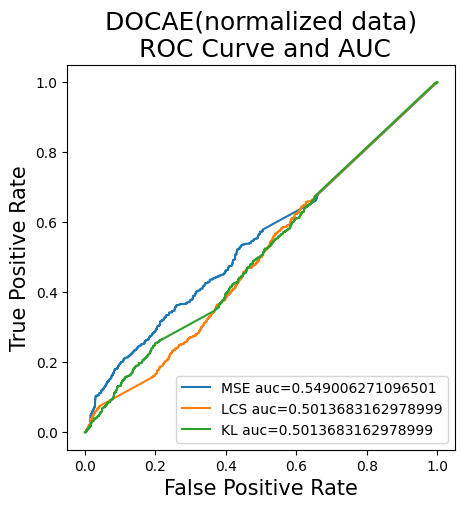

In [ ]:
# ROC & AUC
from sklearn import metrics

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1) 

fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)
fpr_LCS, tpr_LCS, _ = metrics.roc_curve(y_ground_truth,  y_scores_lcs)
auc_LCS = metrics.roc_auc_score(y_ground_truth,  y_scores_lcs)

y_scores_kl = kl_div_test + kl_div_attack
fpr_KL, tpr_KL, _ = metrics.roc_curve(y_ground_truth,  y_scores_kl)
auc_KL = metrics.roc_auc_score(y_ground_truth,  y_scores_kl)


ax.set_title(model_name + '(normalized data)\n ROC Curve and AUC', fontsize = 18)
ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
ax.plot(fpr_LCS,tpr_LCS, label="LCS auc="+str(auc_LCS))
ax.plot(fpr_KL,tpr_KL, label="KL auc="+str(auc_LCS))
ax.set_xlabel("False Positive Rate", fontsize=15)
ax.set_ylabel("True Positive Rate", fontsize=15)
ax.legend(loc=4)

In [ ]:
# classify data
if DATASET == 'network_data':
    model.load_state_dict(torch.load('../model/param_DOCAE_8_8'))
    model.eval()
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
                filterLinearDependencies=True, filter_threshold=0.97, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)
    anomalous_data = torch.tensor(anomalous_data).to(torch.float).to(device)
    idc_to_save = (torch.sum(model.encode(anomalous_data)**2, dim=1) <= model.R**2)
    print(idc_to_save.shape)
    #df = pd.DataFrame(np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_undetected.csv', index=False) #save to file

    #df = pd.DataFrame(anomalous_data[idc_to_save,]) #convert to a dataframe
    #df.to_csv('../data/network_flow_attack_data_temp_undetected.csv', index=False) #save to file

    medical_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')
    df = pd.DataFrame(medical_data[idc_to_save,]) #convert to a dataframe
    df.to_csv('../data/medical_attack_data_undetected.csv', index=False) #save to file
